In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import shutil
import datetime
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

print(tf.__version__)
print(hub.__version__)

2.2.0
0.8.0


In [2]:
train_data = pd.read_csv('../input/shopee-product-detection-student/train.csv')
test_data = pd.read_csv('../input/shopee-product-detection-student/test.csv')

#Train: 79042
#Validation: 26348
#Test: 12186

from sklearn.model_selection import train_test_split

train, valid = train_test_split(train_data, test_size=0.25, random_state=0)
train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)

79042
                               filename  category
0  886c3a8885f1a0fe0afde1e10acd6a39.jpg        16
1  7b7316d672424b861cbaffda79f4c4d6.jpg        24
2  a372b61e116ab57b1cdc003f98a4aecb.jpg        25
3  4d558f913364c84bd7ba7513007d3e84.jpg         3
4  2f590772f7478f38ed129827a8119a73.jpg        41
26348
                               filename  category
0  976aee45fa610646c151915527afe46a.jpg        34
1  06250bea058a3ab769b65679408ea5c4.jpg        26
2  5bc54b48efcf86e3d6f1904aad0591b2.jpg        32
3  4eaaa21a04cb4368ed4e81ac47e60097.jpg         7
4  1e4311f88cf180901d98aa2582680752.jpg        30
AxesSubplot(0.125,0.125;0.775x0.755)


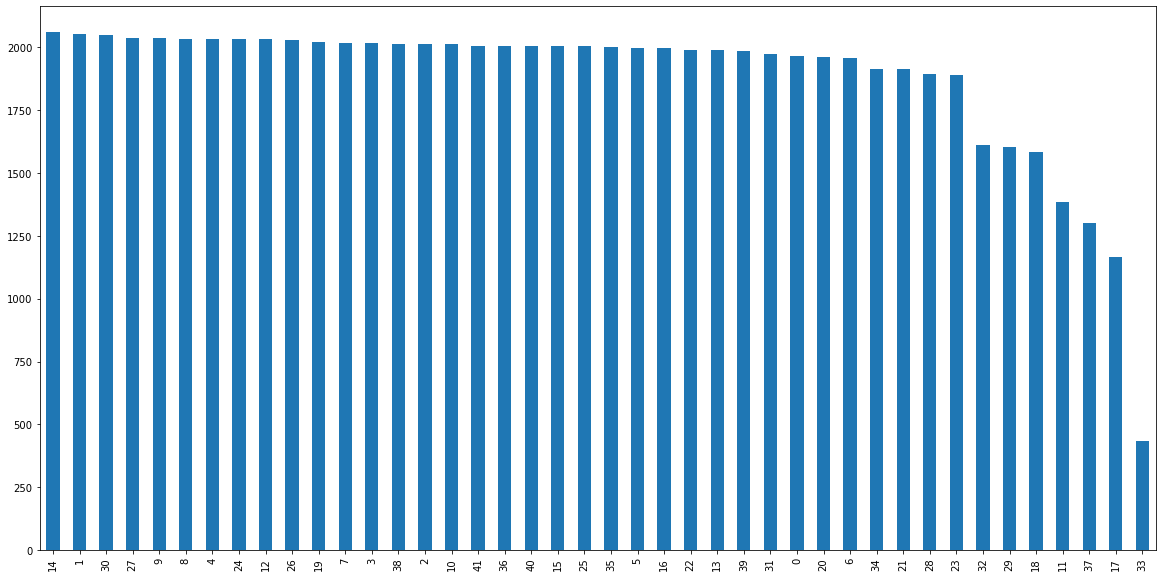

In [3]:
print(len(train))
print(train.head())
print(len(valid))
print(valid.head())
print(train.category.value_counts().plot.bar(figsize=(20,10)))

In [4]:
'''
train = pd.read_csv('../input/productsplit/train_data.csv', index_col=0)
valid = pd.read_csv('../input/productsplit/valid_data.csv', index_col=0)
'''

"\ntrain = pd.read_csv('../input/productsplit/train_data.csv', index_col=0)\nvalid = pd.read_csv('../input/productsplit/valid_data.csv', index_col=0)\n"

In [5]:
train_path = '../input/shopee-product-detection-student/train/train/train/'
test_path = '../input/shopee-product-detection-student/test/test/test/'

def get_filename(i, file):
  return file.filename[i]

def get_category(i, file):
  return str(file.category[i])
             
def foldername_rename(i, file):
  if int(get_category(i, file)) < 10:
    string = '0' + get_category(i, file)
  else:
    string = get_category(i, file)
  return string

def directory_maker(i, file):
    path = train_path + foldername_rename(i, file) + '/' + get_filename(i, file)
    return path

print(get_filename(3, valid))
print(get_category(3, valid))
print(foldername_rename(3, valid))
print(directory_maker(3, valid))

4eaaa21a04cb4368ed4e81ac47e60097.jpg
7
07
../input/shopee-product-detection-student/train/train/train/07/4eaaa21a04cb4368ed4e81ac47e60097.jpg


In [6]:
def create_label(data):
    labels = []

    for i in range(len(data)):
        labels.append(foldername_rename(i, data))
        
    labels = np.array(labels)
    unique_label = np.unique(labels)
    boolean_label = [label == unique_label for label in labels]
    len(boolean_label)
    return boolean_label

def create_filename(data):
    labels = []
    
    for i in range(len(data)):
        labels.append(directory_maker(i, data))
        
    return labels
    
    
def test_directory_maker(test_path):
    names = os.listdir(test_path)
    path = []
    for i in range(len(names)):
        path.append(test_path + names[i])
    return path

train_label = create_label(train)
valid_label = create_label(valid)

train_file = create_filename(train)
valid_file = create_filename(valid)

test_file = test_directory_maker(test_path)

In [7]:
print(train_file[:5])
print(valid_file[:5])
print(test_file[:5])

['../input/shopee-product-detection-student/train/train/train/16/886c3a8885f1a0fe0afde1e10acd6a39.jpg', '../input/shopee-product-detection-student/train/train/train/24/7b7316d672424b861cbaffda79f4c4d6.jpg', '../input/shopee-product-detection-student/train/train/train/25/a372b61e116ab57b1cdc003f98a4aecb.jpg', '../input/shopee-product-detection-student/train/train/train/03/4d558f913364c84bd7ba7513007d3e84.jpg', '../input/shopee-product-detection-student/train/train/train/41/2f590772f7478f38ed129827a8119a73.jpg']
['../input/shopee-product-detection-student/train/train/train/34/976aee45fa610646c151915527afe46a.jpg', '../input/shopee-product-detection-student/train/train/train/26/06250bea058a3ab769b65679408ea5c4.jpg', '../input/shopee-product-detection-student/train/train/train/32/5bc54b48efcf86e3d6f1904aad0591b2.jpg', '../input/shopee-product-detection-student/train/train/train/07/4eaaa21a04cb4368ed4e81ac47e60097.jpg', '../input/shopee-product-detection-student/train/train/train/30/1e4311f

In [8]:
def recheck_data(file, label=None):
    if label != None:
        for i in range(len(file)):
            if file[i].endswith('.jpg') == False:
                print('Deleted ' + file[i] + ', index: ' + i)
                del file[i]
                del label[i]
    else:
        for i in range(len(file)):
            if file[i].endswith('.jpg') == False:
                print('Deleted test ' + file[i] + ', index: ' + i)
                del file[i]
    
recheck_data(train_file, train_label)
recheck_data(valid_file, valid_label)
recheck_data(test_file)

In [9]:
labels = []

for i in range(len(train)):
    labels.append(foldername_rename(i, train))
        
labels = np.array(labels)
unique_labels = np.unique(labels)

In [10]:
def check_dirty(file):
    for i in range(len(file)):
        if file[i].endswith('.jpg') == False:
            print('Data dirty!')
            
check_dirty(train_file)
check_dirty(valid_file)

In [11]:
'''
if os.path.isdir('/kaggle/working/valid/00') is False:
  for i in range(42):
    if i < 10:
      cat = '0' + str(i)
    else:
      cat = str(i)
    os.makedirs('/kaggle/working/valid/' + cat)
    
if os.path.isdir('/kaggle/working/train/00') is False:
  for i in range(42):
    if i < 10:
      cat = '0' + str(i)
    else:
      cat = str(i)
    os.makedirs('/kaggle/working/train/' + cat)
'''

"\nif os.path.isdir('/kaggle/working/valid/00') is False:\n  for i in range(42):\n    if i < 10:\n      cat = '0' + str(i)\n    else:\n      cat = str(i)\n    os.makedirs('/kaggle/working/valid/' + cat)\n    \nif os.path.isdir('/kaggle/working/train/00') is False:\n  for i in range(42):\n    if i < 10:\n      cat = '0' + str(i)\n    else:\n      cat = str(i)\n    os.makedirs('/kaggle/working/train/' + cat)\n"

In [12]:
'''
for i in range(len(valid)):
  filename = get_filename(i, valid)
  category = foldername_rename(i, valid)
  source = '../input/shopee-product-detection-student/train/train/train/' + category + '/' + filename
  dest = '/kaggle/working/valid/' + category + '/' + filename
  shutil.copy(source, dest)

for i in range(len(train)):
  filename = get_filename(i, train)
  category = foldername_rename(i, train)
  source = '../input/shopee-product-detection-student/train/train/train/' + category + '/' + filename
  dest = '/kaggle/working/train/' + category + '/' + filename
  shutil.copy(source, dest)
'''

"\nfor i in range(len(valid)):\n  filename = get_filename(i, valid)\n  category = foldername_rename(i, valid)\n  source = '../input/shopee-product-detection-student/train/train/train/' + category + '/' + filename\n  dest = '/kaggle/working/valid/' + category + '/' + filename\n  shutil.copy(source, dest)\n\nfor i in range(len(train)):\n  filename = get_filename(i, train)\n  category = foldername_rename(i, train)\n  source = '../input/shopee-product-detection-student/train/train/train/' + category + '/' + filename\n  dest = '/kaggle/working/train/' + category + '/' + filename\n  shutil.copy(source, dest)\n"

<h1>Image Processing</h1>

In [13]:
# Image to tensor
IMG_SIZE = 224

def image_process(filepath, imgsize=IMG_SIZE):
    image = tf.io.read_file(filepath)
    
    # RGB
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Convert the color channel values from 0-255
    # to 0-1 values (Normalization)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Resize the image to (192,192)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    return image

def return_label(filepath, label):
    image = image_process(filepath)
    return (image, label)

In [14]:
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    '''
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it is training data but does not shuffle if it is validation data.
    Also accepts test data as inputs (no labels).
    '''
    # Test dataset
    if test_data:
        print('Creating test data batches ...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
        data_batch = data.map(image_process).batch(BATCH_SIZE)
        return data_batch
    
    # Validation dataset
    elif valid_data:
        print('Creating validation data batches ...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # filepaths
                                                   tf.constant(y))) # labels
        data_batch = data.map(return_label).batch(BATCH_SIZE)
        return data_batch
    
    else:
        print('Creating training data batches ...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # filepaths 
                                                   tf.constant(y))) # labels
        
        # Shuffling pathnames
        data = data.shuffle(buffer_size=len(X))
        
        # Create (image,label) tuple
        data = data.map(return_label)
        data_batch = data.batch(BATCH_SIZE)
    
    return data_batch

In [15]:
train_data = create_data_batches(train_file, train_label)
valid_data = create_data_batches(valid_file, valid_label, valid_data=True)
test_data = create_data_batches(test_file, test_data=True)

Creating training data batches ...
Creating validation data batches ...
Creating test data batches ...


In [16]:
print(train_data.element_spec)
print(test_data.element_spec)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 42), dtype=tf.bool, name=None))
TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)


<h1>Batches Visualization</h1>

In [17]:
def show_25_images(images, labels):
    '''
    Displays a plot of 25 images and their labels from a data batch.
    '''
    # Setup the figure
    plt.figure(figsize=(10,10))
    
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_labels[labels[i].argmax()])
        
        plt.axis('off') 

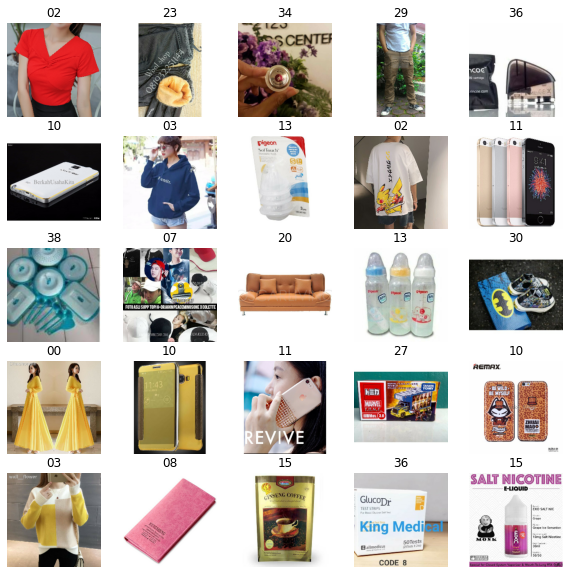

In [18]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [19]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# Setup output shape
OUTPUT_SHAPE = len(unique_labels)

# Setup model URL from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/inception_v3/classification/4'

In [20]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url),
        tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation='softmax')])
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    model.build(INPUT_SHAPE)
    return model

In [21]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  23853833  
_________________________________________________________________
dense (Dense)                multiple                  42084     
Total params: 23,895,917
Trainable params: 42,084
Non-trainable params: 23,853,833
_________________________________________________________________


In [22]:
%load_ext tensorboard

In [23]:
def tensorboard_callback():
    logdir = os.path.join('/kaggle/working/',
                          # Make it so the logs get tracked whenever we run an experiment
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    return tf.keras.callbacks.TensorBoard(logdir)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)

# Create model checkpoint
def create_checkpoint():
    checkdir = os.path.join('/kaggle/working', 'cp.ckpt')
    
    return tf.keras.callbacks.ModelCheckpoint(checkdir, verbose=1, save_best_only=True, mode='max')

In [24]:
NUM_EPOCHS = 3

def train_model():
    '''
    Trains a given model and returns the trained version.
    '''
    # Create a model
    model = create_model()
    
    # Create new TensorBoard session everytime we train a model
    tensorboard = tensorboard_callback()
    
    # Create model checkpoint
    checkpoint = create_checkpoint()
    
    # Fit the model to the data
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=valid_data,
              validation_freq=1,
              callbacks=[tensorboard, early_stopping, checkpoint]
             )
    
    return model

In [25]:
model = train_model()

Epoch 1/3
2471/2471 [==============================] - ETA: 0s - loss: 1.7567 - accuracy: 0.5724
Epoch 00001: val_loss improved from -inf to 1.62195, saving model to /kaggle/working/cp.ckpt
2471/2471 [==============================] - 778s 315ms/step - loss: 1.7567 - accuracy: 0.5724 - val_loss: 1.6220 - val_accuracy: 0.5968
Epoch 2/3
2470/2471 [============================>.] - ETA: 0s - loss: 1.5226 - accuracy: 0.6174
Epoch 00002: val_loss did not improve from 1.62195
2471/2471 [==============================] - 605s 245ms/step - loss: 1.5225 - accuracy: 0.6174 - val_loss: 1.5964 - val_accuracy: 0.6078
Epoch 3/3
2470/2471 [============================>.] - ETA: 0s - loss: 1.4843 - accuracy: 0.6256
Epoch 00003: val_loss did not improve from 1.62195
2471/2471 [==============================] - 601s 243ms/step - loss: 1.4842 - accuracy: 0.6256 - val_loss: 1.5617 - val_accuracy: 0.6161


In [30]:
prediction = model.predict(test_data)

In [43]:
def classify(predict):
    predict_edited = []
    for i in range(len(predict)):
        predict_edited.append(np.argmax(predict[i]))
    return predict_edited

def create_test_dataframe(prediction):
    predict = classify(prediction)
    names = os.listdir(test_path)
    return pd.DataFrame(list(zip(names, predict)), columns = ['filename', 'category'])

In [44]:
df = create_test_dataframe(prediction)

In [51]:
df.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43
2,127f3e6d6e3491b2459812353f33a913.jpg,43
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43
4,46d681a542f2c71be017eef6aae23313.jpg,43


In [56]:
df = pd.read_csv('../input/inceptiontests/default_inception3_3epoch.csv')
df

,filename,category
0,f34822846fc03251d8d5b487330903d1.jpg,17
1,80005b1062e90ee8ea1c39ca5fe41f61.jpg,16
2,db4c464eca3b5c1774061cc0bfcf058d.jpg,24
3,f751a227d63d1323c8538606b1fd4ed2.jpg,3
4,54aa734d8441ea59887258c9819013e1.jpg,22
...,...,...
12187,c2cbdaf34405537e9d2d68c04f6849a8.jpg,26
12188,f7d680571af0115d7d8f19e7fed5ba33.jpg,11
12189,7092a11647030cb9d2ae531a634cece1.jpg,6
12190,87b6718f256627825b3c22d0eaf8f136.jpg,41


In [57]:
df2 = pd.read_csv('../input/shopee-product-detection-student/test.csv')
df2

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43
2,127f3e6d6e3491b2459812353f33a913.jpg,43
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43
4,46d681a542f2c71be017eef6aae23313.jpg,43
...,...,...
12181,5ba958eacb23cd7d1673bad4dae55784.jpg,43
12182,efbe41a1c2b666b70e337e438559808b.jpg,43
12183,79fdaa5ac5ba10dbe8004cabd8c35eb3.jpg,43
12184,ac3d136124617637a05ba66694e381ef.jpg,43


In [58]:
dupli = list(set(df['filename']) - set(df2['filename']))
print(dupli)

['019e994abbd6a49c1846995a480b7883 (1).jpg', '4347e61279df8af5978c15ec5425676b (1).jpg', '10425d5faff26f90d07e3582700829e0 (1).jpg', '2b738be035c8674db9fb2fc0c09b69ce (1).jpg', '105b0d039887573a8266511ba42a7723 (1).jpg', 'abd26f08c2fba98d905d0145661e457e (1).jpg']


In [60]:
dupli_index = []
for i in range(len(df)):
    for j in range(len(dupli)):
        if df.iloc[i,0] == dupli[j]:
            dupli_index.append(i)
            
dupli_index

[1908, 2753, 2767, 4271, 5880, 6000]

In [61]:
df.drop(dupli_index, inplace=True)

In [62]:
df.to_csv('default_inception3_3epoch.csv', index=False)